### IMPORTS

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch
from qwen_vl_utils import process_vision_info
import json
import pandas as pd
from tqdm import tqdm

### Loading model and processor

In [ ]:
# Load model and tokenizer
model_id = "Qwen/Qwen2.5-VL-3B-Instruct" # can be changed to 7B model
model = AutoModelForImageTextToText.from_pretrained(
    model_id, 
    device_map="auto", 
    torch_dtype=torch.bfloat16
)
processor = AutoProcessor.from_pretrained(model_id)


In [ ]:
# using adapter
adapter_path = "adapter_path"
model.load_adapter(adapter_path)

In [ ]:
from datasets import load_from_disk

# dataset loading - this dataset was created during the fine-tuning process
hf_dataset = load_from_disk('dataset_path')

In [5]:
# Split dataset based on the "split" column
train_dataset = hf_dataset.filter(lambda x: x["split"] == "train")
test_dataset = hf_dataset.filter(lambda x: x["split"] == "test")
val_dataset = hf_dataset.filter(lambda x: x["split"] == "val")

# Remove the "split" column as it's no longer needed
train_dataset = train_dataset.remove_columns("split")
test_dataset = test_dataset.remove_columns("split")
val_dataset = val_dataset.remove_columns("split")

Filter:   0%|          | 0/11030 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11030 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11030 [00:00<?, ? examples/s]

In [6]:
system_message = """You are a Vision Language Model specialized in detecting named entities in Ukrainian images containing typewritten words or sentences.
Your task is to analyze the provided image and identify named entities such as names, locations, organizations, and other key terms.
Respond concisely, typically providing the detected entities as a structured list or short phrases.
Focus on accuracy and ensure the extracted entities reflect the text in the image. Avoid additional explanations unless absolutely necessary."""

user_prompt = """Analyze the provided image containing typewritten Ukrainian text. 
Detect and extract named entities belonging to the following categories:
- PERSON (names of individuals)
- LOCATION (geographical places, cities, countries)
- DATE (specific dates, years, or time-related expressions)
- ORG (organizations, institutions, or companies)

Respond with a structured list of detected entities along with their corresponding entity types. 
Ensure accuracy and avoid adding unnecessary explanations."""

def format_data(sample):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": user_prompt,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": json.dumps(sample['label'], indent=2, ensure_ascii=False)}],
        },
    ]

In [9]:
train_dataset = [format_data(sample) for sample in train_dataset]
val_dataset = [format_data(sample) for sample in val_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [11]:
# this will be sent to model
train_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in detecting named entities in Ukrainian images containing typewritten words or sentences.\nYour task is to analyze the provided image and identify named entities such as names, locations, organizations, and other key terms.\nRespond concisely, typically providing the detected entities as a structured list or short phrases.\nFocus on accuracy and ensure the extracted entities reflect the text in the image. Avoid additional explanations unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=434x64>},
   {'type': 'text',
    'text': 'Analyze the provided image containing typewritten Ukrainian text. \nDetect and extract named entities belonging to the following categories:\n- PERSON (names of individuals)\n- LOCATION (geographical places, cities, countries)\n- DATE (specific dates, years, 

In [12]:
# generate function - prepares all necessary data for the inference
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2], tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens, temperature=0.1)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

Model Prediction:  [{'entity': 'LOCATION', 'text': 'УССР'}]
Truth Data:  [{'entity': 'LOCATION', 'text': 'УССР'}]


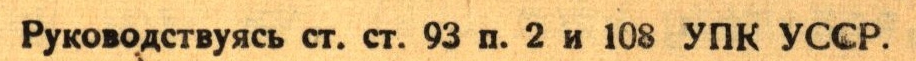

----------------------------------------------------------------------------------------------------


In [46]:
for i in range(0, len(test_dataset)-1):
    output = generate_text_from_sample(model, processor, test_dataset[i])
    if "entity" in str(test_dataset[i][2]):
        print('Model Prediction: ', eval(output))
        print('Truth Data: ', eval(test_dataset[i][2]['content'][0]['text']))
        display(test_dataset[i][1]['content'][0]['image'])
        print('-'*100)
        break
        